In [1]:
import spacy
import numpy as np

In [ ]:
!python3 -m spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg")

In [3]:
import os

file_name = 'transformed_data.json'
path = os.path.join('.', file_name)

In [4]:
import json

with open(path) as f:
  dataset = json.load(f)

In [5]:
instance = dataset[0]

print(instance.keys())

dict_keys(['title', 'text', 'url', 'tokenized_text'])


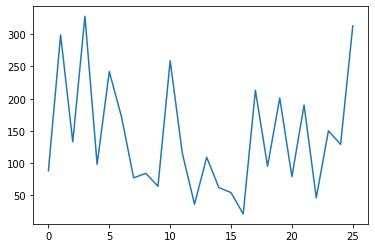

In [11]:
length_of_documents = [len(doc.get('tokenized_text')) for doc in dataset]

from matplotlib import pyplot as plt

plt.plot(length_of_documents)
plt.show()

<h1>Calculating the Tf-IDF!</h1>

In [91]:
from typing import List
from copy import copy
from collections import Counter, OrderedDict

class Corpus:

  def __init__(self, vocabulary) -> None:
      self._vocabulary = vocabulary
      self._lexicon = self._get_lexicon()
      self._document_matrix = np.zeros((self.documents_len, self.lexicon_len))
      self._tf_idf_matrix = copy(self._document_matrix)
      self._vectorize_document()
      self._transform_documents()

  def _vectorize_document(self):
    for doc_i, doc in enumerate(self._vocabulary):
      for term in doc:
        feture_i = self._lexicon.index(term)
        self._document_matrix[doc_i][feture_i] += 1

  def _transform_documents(self):
    for doc_i in range(len(self._tf_idf_matrix)):
      for term_i in range(len(self._tf_idf_matrix[doc_i])):
        tf = self.get_tf(doc_i, term_i)
        idf = self.get_idf(term_i)
        self._tf_idf_matrix[doc_i][term_i] = tf * idf

  def _get_lexicon(self):
    lexicon = set()
    for doc in self._vocabulary:
      for token in doc:
        lexicon.add(token)
    lexicon = list(lexicon)
    return sorted(lexicon)

  def get_tf(self, doc_index, term_index):
    tf = self._document_matrix[doc_index][term_index]
    term_document_count = np.sum(self._document_matrix[doc_index])
    tf = tf / term_document_count
    return tf

  def get_idf(self, term_index):
    nuber_of_documents_with_t = self.term_document_count(term_index)
    idf = self.documents_len / nuber_of_documents_with_t
    idf = np.log(idf)
    return idf

  def term_document_count(self, term_index):
    term_column = self._document_matrix[:, term_index]
    term_column = [int(x > 0) for x in term_column]
    return np.sum(term_column)

  def get_term_index(self, term):
    try:
      index = self._lexicon.index(term)
      return index
    except ValueError:
      return -1

  def get_index_term(self, index):
    return self._lexicon[index]

  @property
  def documents_len(self):
    return len(self._vocabulary)

  @property
  def lexicon_len(self):
    return len(self._lexicon)

  def get_feature_names_out(self):
    return self._lexicon

  def vector_to_dict(self, vec):
    if len(vec) != len(self._tf_idf_matrix[0]):
      raise ValueError('Input vector does not belong to this class.')
    return OrderedDict((self._lexicon[i], x) for i, x in enumerate(vec))

  @property
  def tfidf_matrix(self):
    return self._tf_idf_matrix

  def __len__(self):
    return self.documents_len

  def __iter__(self):
    return self.tfidf_matrix.__iter__()

In [95]:
l = [doc['tokenized_text'] for doc in dataset]

a = Corpus(l)

In [25]:
from spacy.tokens.token import Token

def is_stop_word(token: Token):
  return token.is_stop

def is_punc_or_sym(token: Token):
  part_of_speach = token.pos_
  return (part_of_speach == 'PUNCT' or 
          part_of_speach == 'SYM')
  
def is_punc_or_sym_or_stop(token: Token):
  return is_stop_word(token) or is_punc_or_sym(token)

def tokenize_text(input_string: str):
  spacy_doc = nlp(input_string)
  transformed = [token.lemma_ for token in spacy_doc 
                 if not is_punc_or_sym_or_stop(token)]
  transformed = [lemma.lower() for lemma in transformed]
  return transformed

In [96]:
import math

"""
Author: Natural Language Processing in Action: Understanding, analyzing, 
  and generating text with Python | Hobson Lane,Cole Howard,Hannes Hapke
"""

def cosine_sim(vec1, vec2):
     """ Let's convert our dictionaries to lists for easier matching."""
    #  vec1 = [val for val in vec1.values()]
    #  vec2 = [val for val in vec2.values()]

     dot_prod = 0
     for i, v in enumerate(vec1):
         dot_prod += v * vec2[i]

     mag_1 = math.sqrt(sum([x**2 for x in vec1]))
     mag_2 = math.sqrt(sum([x**2 for x in vec2]))

     return dot_prod / (mag_1 * mag_2)

In [118]:
class Query:

  def __init__(self, query, corpus: Corpus):
    self._query = tokenize_text(query)
    self._corpus = corpus
    self._tf_idf = self._tf_idf()

  def _vectorize_query(self):
    vec = np.zeros(self._corpus.lexicon_len)
    for token in self._query:
      token_index = self._corpus.get_term_index(token)
      if token_index < 0:
        continue  # out of vocabulary
      vec[token_index] += 1
    return vec

  def _tf_idf(self):
    count_vector = self._vectorize_query()

    tf_vector = copy(count_vector)
    for i in range(len(count_vector)):
      tf = count_vector[i]
      term_document_count = np.sum(count_vector)
      tf = tf / term_document_count
      tf_vector[i] = tf

    idf_vector = copy(count_vector)
    for i in range(len(count_vector)):
      nuber_of_documents_with_t = self._corpus.term_document_count(i)
      idf = self._corpus.documents_len / nuber_of_documents_with_t
      idf = np.log(idf)
      idf_vector[i] = idf

    return tf_vector * idf_vector

  @property
  def tf_idf(self):
    return self._tf_idf

  @property
  def dict_tf_idf(self):
    dict_tf_idf = self._corpus.vector_to_dict(self.tf_idf)
    return {k: v for k, v in dict_tf_idf.items() if v > 0}

  def search_result(self):
    result = list()
    for i, doc in enumerate(self._corpus):
      score = cosine_sim(doc, self.tf_idf)
      title = dataset[i]['title']
      link = dataset[i]['url']
      result.append(dict(title=title, score=score, link=link))
    return sorted(result, key=lambda x: x['score'], reverse=True)

In [120]:
query = Query('When did the spanish flu happen', a)
query.search_result()[:5]

[{'link': 'https://en.wikipedia.org/wiki/Spanish_flu',
  'score': 0.32722431725410606,
  'title': 'Spanish flu'},
 {'link': 'https://en.wikipedia.org/wiki/Swine_influenza',
  'score': 0.27806276291630766,
  'title': 'Swine influenza'},
 {'link': 'https://en.wikipedia.org/wiki/Pandemic',
  'score': 0.1262668890689719,
  'title': 'Pandemic'},
 {'link': 'https://en.wikipedia.org/wiki/Unified_Victim_Identification_System',
  'score': 0.024451792853454935,
  'title': 'Unified Victim Identification System'},
 {'link': 'https://en.wikipedia.org/wiki/Epidemiology_of_HIV/AIDS',
  'score': 0.0,
  'title': 'Epidemiology of HIV/AIDS'}]

<h1>Adding the TF-IDF vectors to our dataset!</h1>

In [122]:
new_dataset = copy(dataset)

for i, doc in enumerate(a):
  new_dataset[i].update({'tf_idf': doc.tolist()})

In [128]:
{k:v for k, v in a.vector_to_dict(new_dataset[0]['tf_idf']).items() if v > 0}

{'\n': 0.004828218113241659,
 '14th': 0.037023824295698664,
 '1918': 0.029147151789335645,
 '75–200': 0.037023824295698664,
 'affect': 0.014911208965524645,
 'aids': 0.016662921236288944,
 'black': 0.037023824295698664,
 'century': 0.01873475710894752,
 'continent': 0.037023824295698664,
 'cov-2': 0.024539593742651956,
 'covid-19': 0.016662921236288944,
 'current': 0.029147151789335645,
 'death': 0.00977501437753536,
 'demo': 0.037023824295698664,
 'disease': 0.0220685370809864,
 'endemic': 0.04907918748530391,
 'epidemic': 0.010858084602584504,
 'estimate': 0.010858084602584504,
 'exclude': 0.037023824295698664,
 'fatal': 0.037023824295698664,
 'flu': 0.02127047928297263,
 'generally': 0.024539593742651956,
 'globe': 0.037023824295698664,
 'greek': 0.037023824295698664,
 'history': 0.04254095856594526,
 'hiv': 0.016662921236288944,
 'human': 0.00977501437753536,
 'include': 0.01575334501272603,
 'infected': 0.03332584247257789,
 'infectious': 0.016662921236288944,
 'influenza': 0.0217

<h1>Saving the transfomred dataset</h1>

In [129]:
import json

json_datset = json.dumps(new_dataset)

with open('tf_idf_dataset.json', 'w') as f:
  f.write(json_datset)